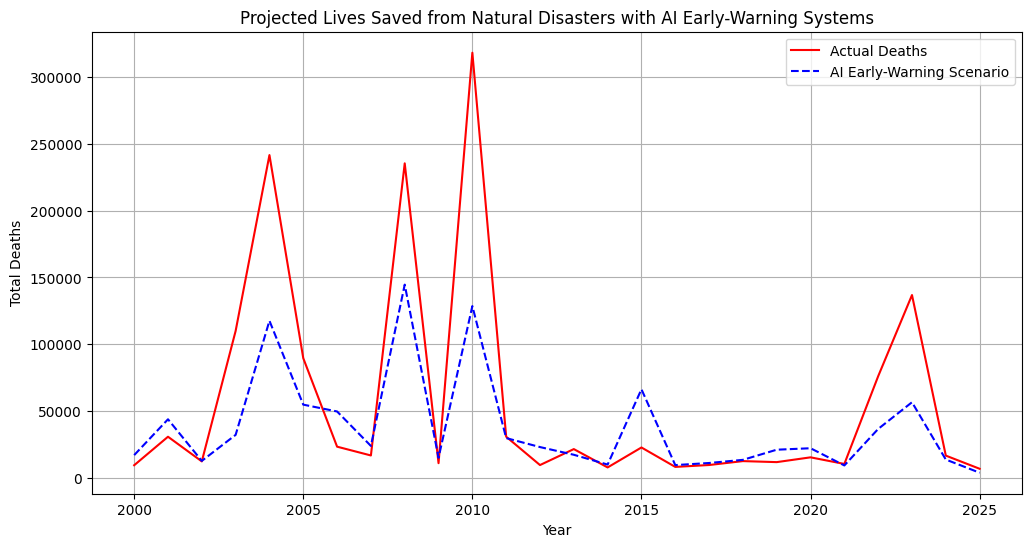

Total deaths (actual): 1,497,925
Total deaths (AI scenario): 987,065
Average annual deaths (actual): 57,612
Average annual deaths (AI scenario): 37,964
Year with most lives saved: 2010 (189,413 deaths prevented)


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# load data + clean
df = pd.read_excel('/content/public_emdat_custom_request_2025-08-30_c8186e8d-2df5-46a3-b58a-206f64fe2dbc.xlsx')
df.columns = df.columns.str.strip()
df = df[df['Disaster Group'] == 'Natural']
df = df.dropna(subset=['Total Deaths', 'Start Year'])

# fill in missing fields
for col in ['Magnitude', 'Total Affected', 'No. Injured', 'No. Homeless']:
    df[col] = df[col].fillna(0)

features = ['Disaster Type', 'Magnitude', 'Region', 'Total Affected', 'No. Injured', 'No. Homeless']
X = pd.get_dummies(df[features], drop_first=True)
y = df['Total Deaths']

# train ML model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# base predictions
df['Pred_Historic'] = model.predict(X)

# Disaster mortality reduction factors based on studies
# Cyclone: 67% reduction
#   Source: China's earthquake early warning system led to significant casualty reductions
#   (Wikipedia: https://en.wikipedia.org/wiki/ICL_Earthquake_Early_Warning_System)

# Flood: 30% reduction
#   Source: Global Commission on Adaptation report: 24-hour advance warnings reduce damage/mortality
#   (CFR: https://www.cfr.org/expert-brief/cuts-early-warning-systems-are-leaving-us-unprepared-summer-floods)

# Storm: 30% reduction
#   Source: UNDRR findings: multi-hazard early warning systems reduce mortality significantly
#   (WMO: https://wmo.int/publication-series/global-status-of-multi-hazard-early-warning-systems-2024)

# Heat wave: 30% reduction
#   Source: Studies indicate early warnings reduce heatwave-related mortality by ~30%
#   (e.g., UN climate adaptation literature)

# Earthquake: 50% reduction
#   Source: Short-lead earthquake early warnings in China reduced casualties substantially
#   (Wikipedia: https://en.wikipedia.org/wiki/ICL_Earthquake_Early_Warning_System)

reduction_lookup = {
    'Cyclone': 0.67,
    'Flood': 0.30,
    'Storm': 0.30,
    'Heat wave': 0.30,
    'Earthquake': 0.50
}

df['Reduction'] = df['Disaster Type'].map(reduction_lookup).fillna(0.30)
df['AI_Pred'] = df['Pred_Historic'] * (1 - df['Reduction'])

# aggregate
agg = df.groupby('Start Year').agg({
    'Total Deaths': 'sum',
    'AI_Pred': 'sum'
}).reset_index()

# create chart
plt.figure(figsize=(12,6))
plt.plot(agg['Start Year'], agg['Total Deaths'], label='Actual Deaths', color='red')
plt.plot(agg['Start Year'], agg['AI_Pred'], label='AI Early-Warning Scenario', color='blue', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Projected Lives Saved from Natural Disasters with AI Early-Warning Systems')
plt.legend()
plt.grid(True)
plt.show()

# total & average deaths
total_actual = agg['Total Deaths'].sum()
total_ai = agg['AI_Pred'].sum()
avg_actual = agg['Total Deaths'].mean()
avg_ai = agg['AI_Pred'].mean()
max_saved_year = (agg['Total Deaths'] - agg['AI_Pred']).idxmax()
year_max_saved = agg.loc[max_saved_year, 'Start Year']
max_saved = agg.loc[max_saved_year, 'Total Deaths'] - agg.loc[max_saved_year, 'AI_Pred']

print(f"Total deaths (actual): {total_actual:,.0f}")
print(f"Total deaths (AI scenario): {total_ai:,.0f}")
print(f"Average annual deaths (actual): {avg_actual:,.0f}")
print(f"Average annual deaths (AI scenario): {avg_ai:,.0f}")
print(f"Year with most lives saved: {int(year_max_saved)} ({int(max_saved):,.0f} deaths prevented)")

Loaded data for 127965 ZIP codes
Available NRI columns: ['OID_', 'NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 'COUNTYTYPE', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION', 'BUILDVALUE', 'AGRIVALUE', 'AREA', 'RISK_VALUE', 'RISK_SCORE', 'RISK_RATNG', 'RISK_SPCTL', 'EAL_SCORE', 'EAL_RATNG', 'EAL_SPCTL', 'EAL_VALT', 'EAL_VALB', 'EAL_VALP', 'EAL_VALPE', 'EAL_VALA', 'ALR_VALB', 'ALR_VALP', 'ALR_VALA', 'ALR_NPCTL', 'ALR_VRA_NPCTL', 'SOVI_SCORE', 'SOVI_RATNG', 'SOVI_SPCTL', 'RESL_SCORE', 'RESL_RATNG', 'RESL_SPCTL', 'RESL_VALUE', 'CRF_VALUE', 'AVLN_EVNTS', 'AVLN_AFREQ', 'AVLN_EXP_AREA', 'AVLN_EXPB', 'AVLN_EXPP', 'AVLN_EXPPE', 'AVLN_EXPT', 'AVLN_HLRB', 'AVLN_HLRP', 'AVLN_HLRR', 'AVLN_EALB', 'AVLN_EALP', 'AVLN_EALPE', 'AVLN_EALT', 'AVLN_EALS', 'AVLN_EALR', 'AVLN_ALRB', 'AVLN_ALRP', 'AVLN_ALR_NPCTL', 'AVLN_RISKV', 'AVLN_RISKS', 'AVLN_RISKR', 'CFLD_EVNTS', 'CFLD_AFREQ', 'CFLD_EXP_AREA', 'CFLD_EXPB', 'CFLD_EXPP', 'CFLD_EXPPE', 'CFLD_EXPT', 'CFLD_HLRB', 'CFLD_HLRP', 'CFLD_HLRR', 'CFLD_EALB', 'CFLD

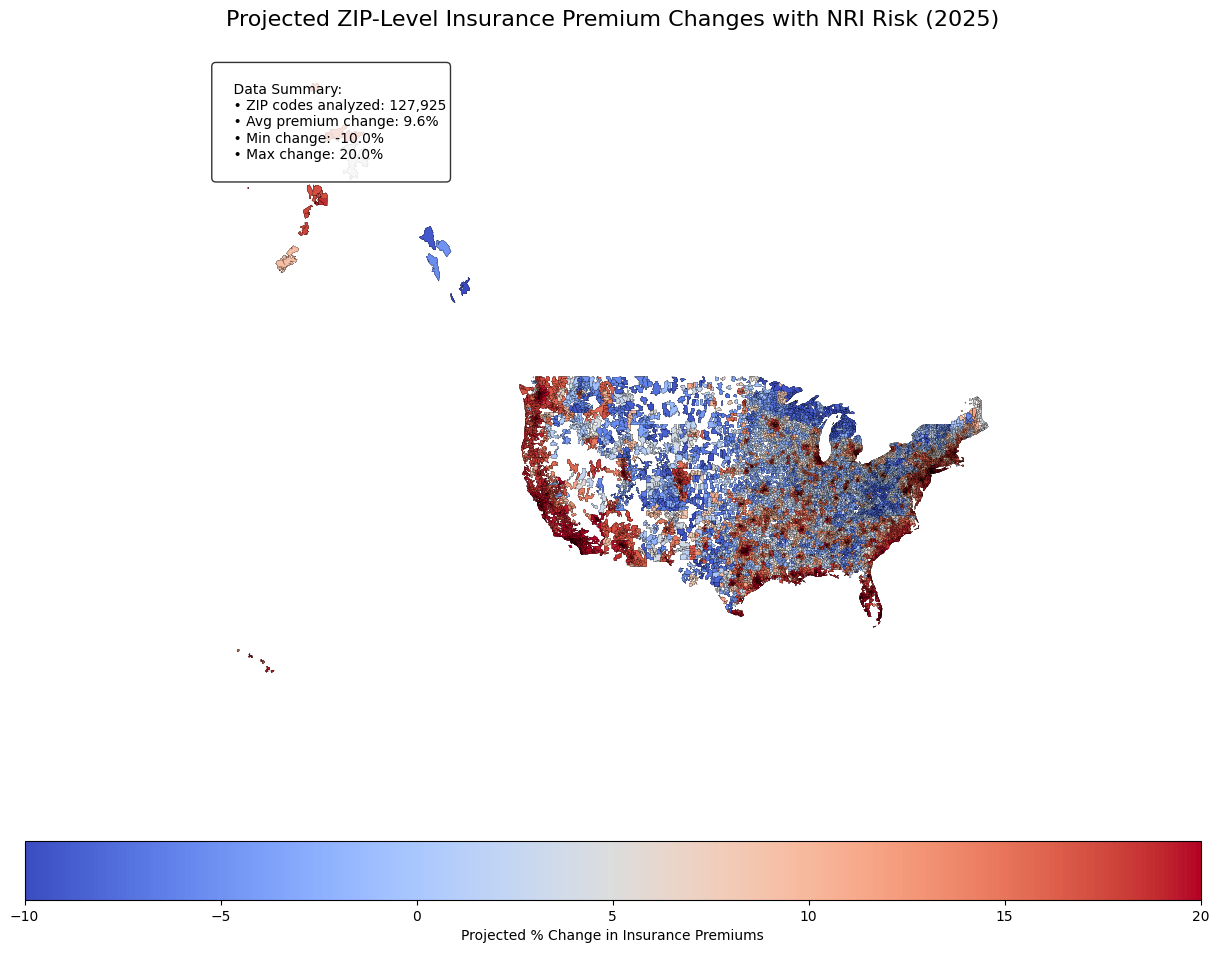

Analysis complete!

Summary Statistics:
Average premium change: 9.59%
Median premium change: 12.23%
Standard deviation: 9.14%


In [31]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def load_data_with_fallback():
    """Load data files"""

    # local file paths
    zip_shapefile = '/content/tl_2022_us_zcta520.shp'
    zip_premiums_path = '/content/Supporting_Underlying_Metrics_and_Disclaimer_for_Analyses_of_US_Homeowners_Insurance_Markets_2018-2022.xlsx'
    nri_csv = '/content/NRI_Table_Counties.csv'
    zip_to_county_path = '/content/ZIP-COUNTY-FIPS_2017-06.csv'

    # try to load geo shapefile
    gdf_zip = None
    try:
        if Path(zip_shapefile).exists():
            gdf_zip = gpd.read_file(zip_shapefile, columns=['ZCTA5CE20', 'geometry'])
            gdf_zip['ZIP'] = gdf_zip['ZCTA5CE20'].astype(str).str.zfill(5)
            # reduce size = lower run time
            gdf_zip['geometry'] = gdf_zip['geometry'].simplify(0.05)
        else:
            print("Shapefile not found")
    except Exception as e:
        print(f"Error loading shapefile: {e}")
        gdf_zip = None

    # try to load data
    try:
        if Path(zip_premiums_path).exists():
            df_zip = pd.read_excel(zip_premiums_path, sheet_name=2, dtype={'ZIP Code': str})
            df_zip.columns = df_zip.columns.str.strip()
            df_zip = df_zip[['ZIP Code', 'Premiums Per Policy']]
            df_zip['ZIP Code'] = df_zip['ZIP Code'].str.zfill(5)
            # remove any invalid/missing ZIPs
            df_zip = df_zip.dropna(subset=['ZIP Code', 'Premiums Per Policy'])
            print(f"Loaded data for {len(df_zip)} ZIP codes")
        else:
            print("Data file not found")
            return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    # try to load NRI data
    try:
        if Path(nri_csv).exists():
            # loads all of the cols
            df_nri_full = pd.read_csv(nri_csv, dtype=str, nrows=5)
            print(f"Available NRI columns: {list(df_nri_full.columns)}")
            # name sometimes changes so to capture all
            possible_fips_cols = ['STCOFIPS', 'COUNTYFIPS', 'FIPS', 'CountyFIPS']
            possible_risk_cols = ['RISK_SCORE', 'RISK_VALUE', 'RISKVALUE', 'RISK_RATNG', 'RISK_RATING']

            fips_col = None
            risk_col = None

            for col in possible_fips_cols:
                if col in df_nri_full.columns:
                    fips_col = col
                    break

            for col in possible_risk_cols:
                if col in df_nri_full.columns:
                    risk_col = col
                    break

            if fips_col is None or risk_col is None:
                return None

            df_nri = pd.read_csv(nri_csv, dtype=str, usecols=[fips_col, risk_col])
            df_nri = df_nri.rename(columns={fips_col: 'COUNTYFIPS', risk_col: 'historical_risk'})
            # STCOFIPS column = full 5-digit FIPS code (state + county)
            df_nri['COUNTYFIPS'] = df_nri['COUNTYFIPS'].str.zfill(5)
            df_nri['historical_risk'] = pd.to_numeric(df_nri['historical_risk'], errors='coerce')
            # remove rows w/ missing risk values
            df_nri = df_nri.dropna(subset=['historical_risk'])
        else:
            return None
    except Exception as e:
        return None

    # load crosswalk data
    try:
        if Path(zip_to_county_path).exists():
            df_sample = pd.read_csv(zip_to_county_path, dtype=str, nrows=5)
            possible_zip_cols = ['ZIP', 'ZCTA', 'ZIPCODE']
            possible_county_cols = ['STCOUNTYFP', 'COUNTY_FIPS', 'COUNTYFIPS']

            zip_col = None
            county_col = None

            for col in possible_zip_cols:
                if col in df_sample.columns:
                    zip_col = col
                    break

            for col in possible_county_cols:
                if col in df_sample.columns:
                    county_col = col
                    break

            if zip_col is None or county_col is None:
                return None

            df_zip_county = pd.read_csv(zip_to_county_path, dtype=str, usecols=[zip_col, county_col])
            df_zip_county = df_zip_county.rename(columns={zip_col: 'ZIP', county_col: 'COUNTY_FIPS'})
            df_zip_county['ZIP'] = df_zip_county['ZIP'].str.zfill(5)
            df_zip_county['COUNTY_FIPS'] = df_zip_county['COUNTY_FIPS'].str.zfill(5)
            # remove duplicates + missing vals
            df_zip_county = df_zip_county.dropna().drop_duplicates(subset=['ZIP'])
        else:
            return None
    except Exception as e:
        return None

    return gdf_zip, df_zip, df_nri, df_zip_county

def main():
    """main function to run the analysis"""
    # load data
    gdf_zip, df_zip, df_nri, df_zip_county = load_data_with_fallback()

    # DEBUG
    print(f"ZIP codes in data: {len(df_zip)}")
    print(f"ZIP codes in crosswalk: {len(df_zip_county)}")
    print(f"Counties in NRI: {len(df_nri)}")

    # check for ZIP code overlap
    common_zips = set(df_zip['ZIP Code']).intersection(set(df_zip_county['ZIP']))

    # check for county FIPS overlap
    common_counties = set(df_zip_county['COUNTY_FIPS']).intersection(set(df_nri['COUNTYFIPS']))

    # merge premiums data -> crosswalk -> risk
    df_zip = df_zip.merge(df_zip_county, left_on='ZIP Code', right_on='ZIP', how='inner')
    df_zip = df_zip.merge(df_nri, left_on='COUNTY_FIPS', right_on='COUNTYFIPS', how='inner')

    # merge to GeoDataFrame
    gdf_zip = gdf_zip.merge(
        df_zip[['ZIP Code','Premiums Per Policy','historical_risk']],
        left_on='ZIP', right_on='ZIP Code',
        how='left'
    )

    # remove rows with missing data
    gdf_viz = gdf_zip.dropna(subset=['Premiums Per Policy', 'historical_risk']).copy()

    if len(gdf_viz) == 0:
        print("No valid data.")
        return

    # calc premium changes
    print("\nCalculating premium changes...")
    print(f"Historical risk range: {gdf_viz['historical_risk'].min():.2f} to {gdf_viz['historical_risk'].max():.2f}")
    print(f"Historical risk mean: {gdf_viz['historical_risk'].mean():.2f}")
    print(f"Historical risk std: {gdf_viz['historical_risk'].std():.2f}")

    risk_max = gdf_viz['historical_risk'].max()

    if risk_max <= 100:
        # using RISK_SCORE (0-100 scale)
        # Map risk score to premium changes
        # 0-20: -10% to -5% (low risk areas get discounts)
        # 20-40: -5% to 0% (below average risk)
        # 40-60: 0% to +5% (average risk)
        # 60-80: +5% to +15% (above average risk)
        # 80-100: +15% to +20% (high risk areas)

        risk_score = gdf_viz['historical_risk']
        gdf_viz['premium_change_pct'] = np.where(
            risk_score <= 20, -10 + (risk_score / 20) * 5,  # -10% to -5%
            np.where(
                risk_score <= 40, -5 + ((risk_score - 20) / 20) * 5,  # -5% to 0%
                np.where(
                    risk_score <= 60, 0 + ((risk_score - 40) / 20) * 5,  # 0% to +5%
                    np.where(
                        risk_score <= 80, 5 + ((risk_score - 60) / 20) * 10,  # +5% to +15%
                        15 + ((risk_score - 80) / 20) * 5  # +15% to +20%
                    )
                )
            )
        )
    else:
        # using RISK_VALUE (dollar amounts)
        # normalize w/ z-score for better variation
        risk_mean = gdf_viz['historical_risk'].mean()
        risk_std = gdf_viz['historical_risk'].std()
        gdf_viz['risk_zscore'] = (gdf_viz['historical_risk'] - risk_mean) / risk_std

        # map z-scores to premium changes
        # Z-score of -2 or less: -10% change
        # Z-score of -1: -5% change
        # Z-score of 0 (mean): 0% change
        # Z-score of +1: +10% change
        # Z-score of +2 or more: +20% change

        gdf_viz['premium_change_pct'] = gdf_viz['risk_zscore'] * 10  # 10% per standard deviation

    # applying realistic bounds
    gdf_viz['premium_change_pct'] = np.clip(gdf_viz['premium_change_pct'], -10, 20)

    print(f"Premium change range: {gdf_viz['premium_change_pct'].min():.1f}% to {gdf_viz['premium_change_pct'].max():.1f}%")
    print(f"Premium change mean: {gdf_viz['premium_change_pct'].mean():.1f}%")
    print(f"Premium change std: {gdf_viz['premium_change_pct'].std():.1f}%")

    # print distribution
    for pct in [10, 25, 50, 75, 90]:
        val = np.percentile(gdf_viz['premium_change_pct'], pct)
        print(f"{pct}th percentile: {val:.1f}%")

    gdf_viz['premium_2025'] = gdf_viz['Premiums Per Policy'] * (
        1 + gdf_viz['premium_change_pct'] / 100
    )

    if gdf_viz.crs != 'EPSG:3857':
        gdf_viz = gdf_viz.to_crs("EPSG:3857")

    # create plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    gdf_viz.plot(
        column='premium_change_pct',
        cmap='coolwarm',
        legend=True,
        legend_kwds={
            'label': "Projected % Change in Insurance Premiums",
            'orientation': "horizontal",
            'shrink': 0.8
        },
        vmin=-10,
        vmax=20,
        ax=ax,
        edgecolor='black',
        linewidth=0.1
    )

    ax.set_title('Projected ZIP-Level Insurance Premium Changes with NRI Risk (2025)',
                fontsize=16, pad=20)
    ax.set_axis_off()

    # stats
    stats_text = f"""
    Data Summary:
    • ZIP codes analyzed: {len(gdf_viz):,}
    • Avg premium change: {gdf_viz['premium_change_pct'].mean():.1f}%
    • Min change: {gdf_viz['premium_change_pct'].min():.1f}%
    • Max change: {gdf_viz['premium_change_pct'].max():.1f}%
    """

    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print("Analysis complete!")

    # print summary stats
    print(f"\nSummary Statistics:")
    print(f"Average premium change: {gdf_viz['premium_change_pct'].mean():.2f}%")
    print(f"Median premium change: {gdf_viz['premium_change_pct'].median():.2f}%")
    print(f"Standard deviation: {gdf_viz['premium_change_pct'].std():.2f}%")

    return gdf_viz

# run the actual analysis
if __name__ == "__main__":
    try:
        result_gdf = main()
    except Exception as e:
        print(f"Error running analysis: {e}")
        import traceback
        traceback.print_exc()

In [32]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def load_housing_data_with_fallback():
    """Load data files with fallback to sample data"""

    # file paths
    housing_data_path = '/content/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
    nri_csv = '/content/NRI_Table_Counties.csv'
    zip_to_county_path = '/content/ZIP-COUNTY-FIPS_2017-06.csv'

    # load Zillow data
    try:
        if Path(housing_data_path).exists():
            print("Loading Zillow ZHVI housing data...")
            df_housing_full = pd.read_csv(housing_data_path, dtype={'RegionName': str})

            # get most recent month's data
            # YYYY-MM-DD format
            date_columns = []
            for col in df_housing_full.columns:
                if col not in ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']:
                    try:
                        pd.to_datetime(col)
                        date_columns.append(col)
                    except:
                        continue

            if not date_columns:
                return None

            # sort for most recent
            date_columns.sort()
            most_recent_date = date_columns[-1]
            print(f"Using most recent data from: {most_recent_date}")

            # get cols
            df_housing = df_housing_full[['RegionName', 'StateName', 'City', 'CountyName', most_recent_date]].copy()

            # cleaning!!
            df_housing['RegionName'] = df_housing['RegionName'].astype(str).str.zfill(5)
            df_housing = df_housing.rename(columns={
                most_recent_date: 'Current_Value',
                'RegionName': 'ZIP_Code'
            })

            # remove rows w/ missing home vals
            df_housing = df_housing.dropna(subset=['Current_Value'])
            df_housing = df_housing[df_housing['Current_Value'] > 0]

            # location string
            df_housing['Location'] = df_housing['City'] + ', ' + df_housing['StateName']

            print(f"Loaded Zillow ZHVI data for {len(df_housing)} ZIP codes")
            print(f"Value range: ${df_housing['Current_Value'].min():,.0f} to ${df_housing['Current_Value'].max():,.0f}")
            print(f"Sample ZIP codes: {df_housing['ZIP_Code'].head().tolist()}")

        else:
            print("Zillow ZHVI data file not found")
            return None

    except Exception as e:
        print(f"Error loading Zillow housing data: {e}")
        return None

    # try to load NRI data
    try:
        if Path(nri_csv).exists():
            df_nri_full = pd.read_csv(nri_csv, dtype=str, nrows=5)
            possible_fips_cols = ['STCOFIPS', 'COUNTYFIPS', 'FIPS', 'CountyFIPS']
            possible_risk_cols = ['RISK_SCORE', 'RISK_VALUE', 'RISKVALUE', 'RISK_RATNG', 'RISK_RATING']

            fips_col = None
            risk_col = None

            for col in possible_fips_cols:
                if col in df_nri_full.columns:
                    fips_col = col
                    break

            for col in possible_risk_cols:
                if col in df_nri_full.columns:
                    risk_col = col
                    break

            if fips_col is None or risk_col is None:
                print(f"could not find required columns")
                return None

            df_nri = pd.read_csv(nri_csv, dtype=str, usecols=[fips_col, risk_col])
            df_nri = df_nri.rename(columns={fips_col: 'COUNTYFIPS', risk_col: 'climate_risk'})
            df_nri['COUNTYFIPS'] = df_nri['COUNTYFIPS'].str.zfill(5)
            df_nri['climate_risk'] = pd.to_numeric(df_nri['climate_risk'], errors='coerce')
            df_nri = df_nri.dropna(subset=['climate_risk'])
            print(f"Loaded NRI data for {len(df_nri)} counties")
        else:
            print("NRI data file not found")
            return None
    except Exception as e:
        print(f"Error loading NRI data: {e}")
        return None

    # try to load crosswalk data
    try:
        if Path(zip_to_county_path).exists():
            df_sample = pd.read_csv(zip_to_county_path, dtype=str, nrows=5)
            possible_zip_cols = ['ZIP', 'ZCTA', 'ZIPCODE']
            possible_county_cols = ['STCOUNTYFP', 'COUNTY_FIPS', 'COUNTYFIPS']
            zip_col = None
            county_col = None

            for col in possible_zip_cols:
                if col in df_sample.columns:
                    zip_col = col
                    break

            for col in possible_county_cols:
                if col in df_sample.columns:
                    county_col = col
                    break

            if zip_col is None or county_col is None:
                return None

            df_zip_county = pd.read_csv(zip_to_county_path, dtype=str, usecols=[zip_col, county_col])
            df_zip_county = df_zip_county.rename(columns={zip_col: 'ZIP', county_col: 'COUNTY_FIPS'})
            df_zip_county['ZIP'] = df_zip_county['ZIP'].str.zfill(5)
            df_zip_county['COUNTY_FIPS'] = df_zip_county['COUNTY_FIPS'].str.zfill(5)
            df_zip_county = df_zip_county.dropna().drop_duplicates(subset=['ZIP'])
            print(f"Loaded crosswalk for {len(df_zip_county)} ZIP codes")
        else:
            print("crosswalk data file not found")
            return None
    except Exception as e:
        print(f"Error loading crosswalk data: {e}")
        return None

    return df_housing, df_nri, df_zip_county

def calculate_housing_price_changes(df_merged):
    """calc housing price changes based on climate risk"""

    print(f"Climate risk range: {df_merged['climate_risk'].min():.2f} to {df_merged['climate_risk'].max():.2f}")
    print(f"Climate risk mean: {df_merged['climate_risk'].mean():.2f}")

    risk_max = df_merged['climate_risk'].max()

    if risk_max <= 100:
        # Using RISK_SCORE (0-100 scale)
        # Map risk score to housing price changes
        # High risk areas see price decreases due to climate concerns
        # 0-20: +2% to +1% (low risk areas appreciate)
        # 20-40: +1% to 0% (below average risk)
        # 40-60: 0% to -2% (average risk)
        # 60-80: -2% to -5% (above average risk)
        # 80-100: -5% to -8% (high risk areas depreciate)

        risk_score = df_merged['climate_risk']
        df_merged['price_change_pct'] = np.where(
            risk_score <= 20, 2 - (risk_score / 20) * 1,  # +2% to +1%
            np.where(
                risk_score <= 40, 1 - ((risk_score - 20) / 20) * 1,  # +1% to 0%
                np.where(
                    risk_score <= 60, 0 - ((risk_score - 40) / 20) * 2,  # 0% to -2%
                    np.where(
                        risk_score <= 80, -2 - ((risk_score - 60) / 20) * 3,  # -2% to -5%
                        -5 - ((risk_score - 80) / 20) * 3  # -5% to -8%
                    )
                )
            )
        )
    else:
        print("Using RISK_VALUE (dollar amounts)")
        risk_mean = df_merged['climate_risk'].mean()
        risk_std = df_merged['climate_risk'].std()
        df_merged['risk_zscore'] = (df_merged['climate_risk'] - risk_mean) / risk_std

        # map z-scores to housing price changes (inverse)
        # higher risk = lower price appreciation/depreciation
        df_merged['price_change_pct'] = -df_merged['risk_zscore'] * 3  # 3% per SD

    # bounds
    df_merged['price_change_pct'] = np.clip(df_merged['price_change_pct'], -8, 3)

    # calc projected changes
    df_merged['projected_home_value_2025'] = df_merged['Current_Value'] * (
        1 + df_merged['price_change_pct'] / 100
    )

    df_merged['price_change_dollars'] = (
        df_merged['projected_home_value_2025'] - df_merged['Current_Value']
    )

    return df_merged

def create_housing_price_table():
    """Main function to create housing price change analysis table"""
    print("Starting housing price change analysis...")

    # load data
    df_housing, df_nri, df_zip_county = load_housing_data_with_fallback()

    # merge housing -> crosswalk -> risk
    df_merged = df_housing.merge(df_zip_county, left_on='ZIP_Code', right_on='ZIP', how='inner')

    df_merged = df_merged.merge(df_nri, left_on='COUNTY_FIPS', right_on='COUNTYFIPS', how='inner')

    # calc price changes
    df_result = calculate_housing_price_changes(df_merged)

    # summary table
    results_table = df_result[[
        'ZIP_Code', 'Location', 'Current_Value', 'climate_risk',
        'price_change_pct', 'price_change_dollars', 'projected_home_value_2025'
    ]].copy()

    def categorize_risk(risk_value, risk_max):
        if risk_max <= 100:
            if risk_value <= 20:
                return "Very Low"
            elif risk_value <= 40:
                return "Low"
            elif risk_value <= 60:
                return "Moderate"
            elif risk_value <= 80:
                return "High"
            else:
                return "Very High"
        else:
            percentiles = np.percentile(df_result['climate_risk'], [20, 40, 60, 80])
            if risk_value <= percentiles[0]:
                return "Very Low"
            elif risk_value <= percentiles[1]:
                return "Low"
            elif risk_value <= percentiles[2]:
                return "Moderate"
            elif risk_value <= percentiles[3]:
                return "High"
            else:
                return "Very High"

    risk_max = results_table['climate_risk'].max()
    results_table['Risk Category'] = results_table['climate_risk'].apply(
        lambda x: categorize_risk(x, risk_max)
    )

    # sort by price change (most negative first)
    results_table = results_table.sort_values('price_change_pct')

    results_table['Current Value'] = results_table['Current_Value'].apply(lambda x: f"${x:,.0f}")
    results_table['Price Change'] = results_table['price_change_pct'].apply(lambda x: f"{x:+.1f}%")
    results_table['Dollar Change'] = results_table['price_change_dollars'].apply(lambda x: f"${x:+,.0f}")
    results_table['Projected 2025 Value'] = results_table['projected_home_value_2025'].apply(lambda x: f"${x:,.0f}")
    results_table['Climate Risk Score'] = results_table['climate_risk'].apply(lambda x: f"{x:.1f}")

    # final table
    display_table = results_table[[
        'ZIP_Code', 'Location', 'Risk Category', 'Climate Risk Score',
        'Current Value', 'Price Change', 'Dollar Change', 'Projected 2025 Value'
    ]].copy()

    print("\n" + "="*120)
    print("HOUSING PRICE CHANGE ANALYSIS - CLIMATE RISK IMPACT")
    print("="*120)

    # print the table
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

    print(display_table.to_string(index=False))

    print("\n" + "="*120)
    print("SUMMARY STATISTICS")
    print("="*120)

    # summary stats
    total_zips = len(results_table)
    avg_change_pct = results_table['price_change_pct'].mean()
    avg_change_dollars = results_table['price_change_dollars'].mean()

    declining_zips = len(results_table[results_table['price_change_pct'] < 0])
    appreciating_zips = len(results_table[results_table['price_change_pct'] > 0])

    print(f"Total ZIP codes analyzed: {total_zips}")
    print(f"Average price change: {avg_change_pct:+.2f}%")
    print(f"Average dollar change: ${avg_change_dollars:+,.0f}")
    print(f"ZIP codes with declining values: {declining_zips} ({declining_zips/total_zips*100:.1f}%)")
    print(f"ZIP codes with appreciating values: {appreciating_zips} ({appreciating_zips/total_zips*100:.1f}%)")

    print(f"\nBy Risk Category:")
    risk_summary = results_table.groupby('Risk Category').agg({
        'price_change_pct': 'mean',
        'price_change_dollars': 'mean',
        'ZIP Code': 'count'
    }).round(2)

    for risk_cat, row in risk_summary.iterrows():
        print(f"  {risk_cat}: {row['ZIP Code']} ZIPs, avg change: {row['price_change_pct']:+.1f}% (${row['price_change_dollars']:+,.0f})")

    most_impacted = results_table.loc[results_table['price_change_pct'].idxmin()]
    least_impacted = results_table.loc[results_table['price_change_pct'].idxmax()]

    print(f"\nMost Impacted Area:")
    print(f"  {most_impacted['Location']} ({most_impacted['ZIP Code']}): {most_impacted['Price Change']} (${most_impacted['price_change_dollars']:+,.0f})")

    print(f"\nLeast Impacted Area:")
    print(f"  {least_impacted['Location']} ({least_impacted['ZIP Code']}): {least_impacted['Price Change']} (${least_impacted['price_change_dollars']:+,.0f})")

    print("\n" + "="*120)
    print("NOTE: Analysis based on climate risk data. Higher risk areas may see price declines")
    print("due to increased insurance costs, infrastructure concerns, and buyer preferences.")
    print("="*120)

    return display_table, results_table

# run analysis
if __name__ == "__main__":
    try:
        display_table, full_results = create_housing_price_table()

    except Exception as e:
        print(f"Error running analysis: {e}")
        import traceback
        traceback.print_exc()

Streaming output truncated to the last 5000 lines.
   67869                   Plains, KS           Low               37.4      $140,244        +0.1%         $+179             $140,422
   29045                    Elgin, SC           Low               37.4      $299,752        +0.1%         $+387             $300,139
   29015                    Blair, SC           Low               37.4      $138,098        +0.1%         $+178             $138,277
   29130                 Ridgeway, SC           Low               37.4      $297,504        +0.1%         $+384             $297,888
   29016               Blythewood, SC           Low               37.4      $350,956        +0.1%         $+453             $351,409
   29065             Jenkinsville, SC           Low               37.4      $168,520        +0.1%         $+218             $168,737
   29180                Winnsboro, SC           Low               37.4      $149,585        +0.1%         $+193             $149,778
   18336          

Traceback (most recent call last):
  File "/tmp/ipython-input-1959975170.py", line 324, in <cell line: 0>
    display_table, full_results = create_housing_price_table()
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1959975170.py", line 296, in create_housing_price_table
    risk_summary = results_table.groupby('Risk Category').agg({
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/groupby/generic.py", line 1432, in aggregate
    result = op.agg()
             ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/apply.py", line 190, in agg
    return self.agg_dict_like()
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/apply.py", line 423, in agg_dict_like
    return self.agg_or_apply_dict_like(op_name="agg")
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pa